
    Choose a language model that will best represent the input text.
    Clean and prepare the data for training.
    Build a basic Keras sequential neural network model.
    Apply recurrent neural network (RNN) to process character sequences.
    Generate 3 channel RGB color outputs.


In [1]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Reshape

import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('colors.csv')
names = data['name']
data.head()

,name,red,green,blue
0,18th Century Green,165,147,68
1,1975 Earth Red,123,70,59
2,1989 Miami Hotline,221,51,102
3,20000 Leagues Under the Sea,25,25,112
4,3AM in Shibuya,34,85,119


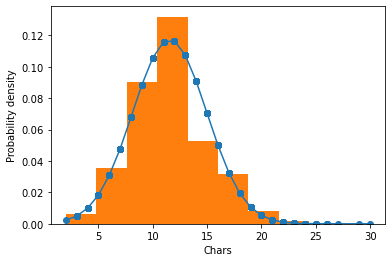

In [5]:
h = sorted(names.str.len().values)

import scipy.stats as stats
import pylab as plt

fit = stats.norm.pdf(h,np.mean(h),np.std(h))
plt.plot(h,fit,'-o')
plt.hist(h,density=True)
plt.xlabel('Chars')
plt.ylabel('Probability density')
plt.show()

That gives us this plot, and you can clearly see that the majority of the color name strings have lengths less or equal to 25, even though the max length goes up to 30.

We could, in our case, pick the max length of 30, but the model we’re going to build would also need to be trained on longer sequences for an extended time. Our trade-off to pick shorter sequence length reduces the model training complexity while not compromising the integrity of the training data.

With the decision of max length being made, the next step in the character-level data pre-processing is to transform each color name string to a list of 25 integer values, and this is made easy with the Keras text tokenization utility.

In [6]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized,maxlen=maxlen)
print(padded_names.shape)

(18606, 25)


Right now, padded_names will have the shape of (18606, 25), with 18,606 is the number of total training samples and 25 being the max sequence length. If a string has less than 25 characters, it will be padded with the value 0 from the beginning of the sequence.

In [7]:
print(t.word_index)

{'e': 1, 'a': 2, ' ': 3, 'r': 4, 'i': 5, 'l': 6, 'n': 7, 'o': 8, 's': 9, 't': 10, 'c': 11, 'u': 12, 'd': 13, 'g': 14, 'p': 15, 'h': 16, 'b': 17, 'm': 18, 'y': 19, 'w': 20, 'k': 21, 'f': 22, 'v': 23, 'z': 24, 'j': 25, 'q': 26, 'x': 27, "'": 28, '-': 29, 'ō': 30, 'è': 31, 'é': 32, 'ā': 33, 'á': 34, 'ó': 35, 'ū': 36, '0': 37, '8': 38, '.': 39, 'ē': 40, 'ī': 41, 'ǎ': 42, '!': 43, 'í': 44, '&': 45, 'ǜ': 46, '9': 47, '2': 48, 'à': 49, 'ǐ': 50, '’': 51, '6': 52, 'ú': 53, '1': 54, '3': 55, 'â': 56, '4': 57, 'ǔ': 58, 'ì': 59, '7': 60, '5': 61, 'ê': 62, 'ö': 63, 'ł': 64, 'š': 65, 'ü': 66, '₂': 67, 'ò': 68, 'ñ': 69, 'ě': 70, 'ń': 71, 'ä': 72, 'œ': 73, 'ß': 74, '%': 75, 'ı': 76, 'ż': 77, '/': 78, 'î': 79, 'ë': 80, '(': 81, ')': 82, 'å': 83, '$': 84, 'я': 85, 'ő': 86, 'ğ': 87, 'ç': 88, 'ù': 89}


In [9]:
from tensorflow.python.keras.utils import np_utils

one_hot_names = np_utils.to_categorical(padded_names)

## Data normalization

In [10]:
# The RGB values are between 0-255
# scale to 0-1

def norm(value):
    return value/255.0

normalized_values = np.column_stack([norm(data['red']),norm(data['green']),norm(data['blue'])])

## Building the model

To build our model we’re going to use two types of neural networks: a feed-forward neural network and a recurrent neural network. The feed-forward neural network is by far the most common type of neural network. In this neural network, the information comes into the input units and flows in one direction through hidden layers until each reaches the output units.

In recurrent neural networks, information can flow around in cycles. These networks can remember information for a long time. Recurrent networks are a very natural way to model sequential data. In our specific model, we’re using one of the most powerful recurrent networks named long short term memory (LSTM).

The easiest way to build a deep learning model in Keras is to use its sequential API, and we simply connect each of the neural network layers by calling its model.add() function like connecting LEGO bricks.

In [13]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen,90)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [14]:
history = model.fit(one_hot_names, normalized_values, epochs=40, batch_size=32, validation_split=0.2)

Epoch 1/40
466/466 [==============================] - 35s 74ms/step - loss: 0.0685 - acc: 0.5816 - val_loss: 0.0638 - val_acc: 0.5306
Epoch 2/40
466/466 [==============================] - 34s 72ms/step - loss: 0.0638 - acc: 0.6219 - val_loss: 0.0644 - val_acc: 0.5981
Epoch 3/40
466/466 [==============================] - 33s 71ms/step - loss: 0.0610 - acc: 0.6303 - val_loss: 0.0601 - val_acc: 0.6048
Epoch 4/40
466/466 [==============================] - 33s 72ms/step - loss: 0.0584 - acc: 0.6341 - val_loss: 0.0584 - val_acc: 0.5774
Epoch 5/40
466/466 [==============================] - 33s 72ms/step - loss: 0.0558 - acc: 0.6444 - val_loss: 0.0577 - val_acc: 0.6214
Epoch 6/40
466/466 [==============================] - 33s 72ms/step - loss: 0.0537 - acc: 0.6404 - val_loss: 0.0559 - val_acc: 0.6214
Epoch 7/40
466/466 [==============================] - 33s 71ms/step - loss: 0.0516 - acc: 0.6426 - val_loss: 0.0570 - val_acc: 0.6255
Epoch 8/40
466/466 [==============================] - 33s 71ms

## Generate colors

Let’s define some functions to generate and show the color predicted.

For a color name input, we need to transform it into the same one-hot representation. To achieve this, we tokenize characters to integers with the same tokenizer with which we processed the training data, pad it to the max sequence length of 25, then apply the one-hot encoding to the integer sequence.

And for the output RGB values, we need to scale it back to 0–255, so we can display them correctly

In [20]:
# plot a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data,interpolation='nearest')
    plt.show()
    
def scale(n):
    return int(n*255)

def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=90)
    pred = model.predict(np.array(one_hot))[0]
    r,g,b = scale(pred[0]),scale(pred[1]),scale(pred[2])
    print(name + ',', 'R,G,B: ', r,g,b)
    plot_rgb(pred)

forest, R,G,B:  25 77 31


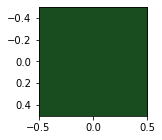

ocean, R,G,B:  7 75 131


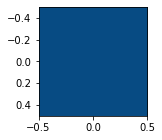

In [21]:
predict('forest')
predict('ocean')

In this post, we talked about how to build a Keras model that can take any color name and come up with an RGB color value. More specifically, we looked at how to apply the one-hot encoding to character-level language models, building a neural network model with a feed-forward neural network and recurrent neural network.